In [78]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeRegressor

from cluster_similarity import ClusterSimilarity
from data import load_housing_data

In [48]:
housing = load_housing_data()

# Preparing the data

## Stratification

Inside knowledge tells you that the median income is an important predictor for the median house price. It is important to make sure that the test set is representative of the income _strata_.

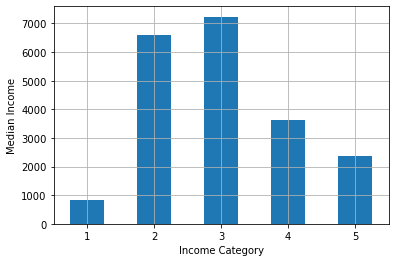

In [49]:
# Create an income category column
housing['income_cat'] = pd.cut(housing['median_income'],
                               bins=[0, 1.5, 3, 4.5, 6, np.Inf],
                               labels=[1, 2, 3, 4, 5])
# Plot histogram
housing['income_cat'].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel('Income Category')
plt.ylabel('Median Income')
plt.show()

The income category now can help to do stratified sampling for the test set!

In [50]:
splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

# When used, the splitter returns the train and test *indexes*, it is therefore necessary to reconstruct the dataframes from the splits.
stratified_train_set, stratified_test_set = train_test_split(housing, test_size=0.2, random_state=42,
                                                             stratify=housing["income_cat"])

# Drop the income_cat column since it won't be used again
for set_ in (stratified_test_set, stratified_train_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [51]:
housing_test = stratified_test_set.copy()

# Drop the value from the predictor: `median_house_value`
housing = stratified_train_set.drop("median_house_value", axis=1)
# Create the labels to train the model later on
housing_labels = stratified_train_set["median_house_value"].copy()

housing.shape

(16512, 9)

In [52]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987,NEAR BAY
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876,<1H OCEAN
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330,INLAND
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618,INLAND
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292,NEAR OCEAN


In [53]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 13096 to 19888
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16344 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   ocean_proximity     16512 non-null  object 
dtypes: float64(8), object(1)
memory usage: 1.3+ MB


In [54]:
# Inspect the ocean proximity feature
housing["ocean_proximity"].value_counts()

<1H OCEAN     7274
INLAND        5301
NEAR OCEAN    2089
NEAR BAY      1846
ISLAND           2
Name: ocean_proximity, dtype: int64

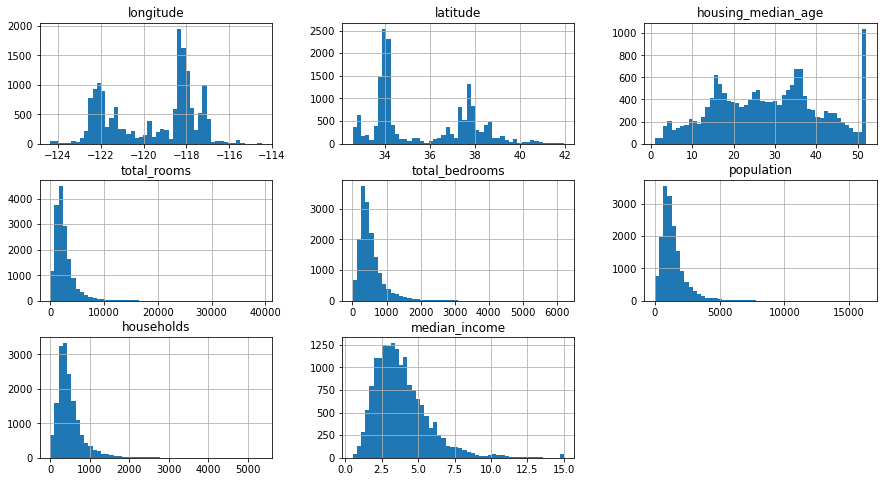

In [55]:
housing.hist(bins=50, figsize=(15, 8))
plt.show()

# Creating a pipeline

The dataset was explored in the file `house_prices_exploration.ipynb`. Now we're going to define a set of transformations to apply to the data using a pipeline, in order to prepare it for an ML algorithm. These are the transformations:

- Imputation: Replace missing values. For numerical features we'll replace missing values by the median. For categorical features we'll replace missing values by the most frequent category.
- One-hot encoding: The categorical feature "ocean_proximity" will be one-hot encoded as most ML algorithms accept only numerical inputs.
- Compute ratio features: We've seen that some computed features, such as the bedroom-room ratio have a better correlation to the house price, so let's add the ratio features: `bedrooms_ratio`, `rooms_per_house`, and `people_per_house`
- Cluster similarity features: We've observed that there are a few population centers where prices seem to be higher (see `house_prices_exploration.ipynb`). Cluster similarity features might be more useful for ML algorithms than the raw coordinates.
- Process _long and/or heavy-tailed_ features: Features that are long and/or heavy tailed will be replaced by their logarithm in order to obtain a more gaussian-looking distribution.
- Standardization: Process features, so they end up with a mean of 1 (or 0) and a standard deviation of 1. Most ML algorithms prefer when features have roughly the same scale.

In [56]:
def column_ratio(X):
    """
    Returns the ratio of the first column to the second column
    :param X: 2-dimensional array
    :return: 2-dimensional array where the second dimension corresponds to the ratio of the first column to the second column
    """
    return X[:, [0]] / X[:, [1]]


def ratio_name(feature_transformer, feature_names_in):
    """
    Used for the transformer functions to get feature names out.
    :param feature_transformer:
    :param feature_names_in:
    :return:
    """
    return ["ratio"]


def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(column_ratio, feature_names_out=ratio_name),
        StandardScaler()
    )


log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler()
)

cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1, random_state=42)

default_num_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler()
)

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore")
)

preprocessing = ColumnTransformer([
    ("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
    ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
    ("people_per_home", ratio_pipeline(), ["population", "households"]),
    ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population", "households", "median_income"]),
    ("geo", cluster_simil, ["latitude", "longitude"]),
    ("cat", cat_pipeline, make_column_selector(dtype_include=object))
],
    remainder=default_num_pipeline
)

housing_prepared = preprocessing.fit_transform(housing)
housing_prepared.shape

(16512, 24)

In [57]:
preprocessing.get_feature_names_out()

array(['bedrooms__ratio', 'rooms_per_house__ratio',
       'people_per_home__ratio', 'log__total_bedrooms',
       'log__total_rooms', 'log__population', 'log__households',
       'log__median_income', 'geo__Cluster 0 similarity',
       'geo__Cluster 1 similarity', 'geo__Cluster 2 similarity',
       'geo__Cluster 3 similarity', 'geo__Cluster 4 similarity',
       'geo__Cluster 5 similarity', 'geo__Cluster 6 similarity',
       'geo__Cluster 7 similarity', 'geo__Cluster 8 similarity',
       'geo__Cluster 9 similarity', 'cat__ocean_proximity_<1H OCEAN',
       'cat__ocean_proximity_INLAND', 'cat__ocean_proximity_ISLAND',
       'cat__ocean_proximity_NEAR BAY', 'cat__ocean_proximity_NEAR OCEAN',
       'remainder__housing_median_age'], dtype=object)

# Training the model

In [58]:
lin_reg = make_pipeline(
    preprocessing, LinearRegression()
)
lin_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x7fe...
                                                   'median_income']),
                                                 ('geo',
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fe218da8a60>)])),
                ('linearregression', LinearRegression())])

In [61]:
housing_predictions = lin_reg.predict(housing)
housing_predictions[:5].round(-2)

array([243700., 372400., 128800.,  94400., 328300.])

In [62]:
housing_labels[:5].round(-2)

13096    458300.0
14973    483800.0
3785     101700.0
14689     96100.0
20507    361800.0
Name: median_house_value, dtype: float64

# Measure model's performance

We chose RMSE (Root-Mean Squared Error), which is available from Scikit-Learn

In [66]:
lin_rmse = mean_squared_error(housing_labels, housing_predictions, squared=False)
lin_rmse.round(-2)

68700.0

A RMSE of around 68,700 USD is not good enough when the house prices range from 120,000 USD to 250,000 USD.

The model might be underfitting the data. Maybe the features do not provide enough information or the model is not powerful enough.
To fix underfitting, one of the possible solutions is to select a more powerful model. This can be easier than adding further fixtures first.

Let's try first with a decision tree model and see what happens.

In [70]:
tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42))
tree_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x7fe...
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fe218da8a60>)])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

In [72]:
housing_predictions = tree_reg.predict(housing)

tree_rmse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse.round(-2)

0.0

An error of 0.0 most likely means that the model is overfitting the data. Try to measure the model's performance now with cross validation.

With Scikit-Learn's k-fold cross validation, the model is split into, say 10, non-overlapping subsets called folds. Then the model is trained and evaluated 10 times, each time using a different fold for evaluation and the other 9 folds as training data. This results in 10 different scores, which might give a better overview of the model's performance.

In [ ]:
tree_rmses =  #%%
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeRegressor

from cluster_similarity import ClusterSimilarity
from data import load_housing_data

In [ ]:
housing = load_housing_data()

# Preparing the data

## Stratification

Inside knowledge tells you that the median income is an important predictor for the median house price. It is important to make sure that the test set is representative of the income _strata_.

In [ ]:
# Create an income category column
housing['income_cat'] = pd.cut(housing['median_income'],
                               bins=[0, 1.5, 3, 4.5, 6, np.Inf],
                               labels=[1, 2, 3, 4, 5])
# Plot histogram
housing['income_cat'].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel('Income Category')
plt.ylabel('Median Income')
plt.show()

The income category now can help to do stratified sampling for the test set!

In [ ]:
splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

# When used, the splitter returns the train and test *indexes*, it is therefore necessary to reconstruct the dataframes from the splits.
stratified_train_set, stratified_test_set = train_test_split(housing, test_size=0.2, random_state=42,
                                                             stratify=housing["income_cat"])

# Drop the income_cat column since it won't be used again
for set_ in (stratified_test_set, stratified_train_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [ ]:
housing_test = stratified_test_set.copy()

# Drop the value from the predictor: `median_house_value`
housing = stratified_train_set.drop("median_house_value", axis=1)
# Create the labels to train the model later on
housing_labels = stratified_train_set["median_house_value"].copy()

housing.shape

In [ ]:
housing.head()

In [ ]:
housing.info()

In [ ]:
# Inspect the ocean proximity feature
housing["ocean_proximity"].value_counts()

In [ ]:
housing.hist(bins=50, figsize=(15, 8))
plt.show()

# Creating a pipeline

The dataset was explored in the file `house_prices_exploration.ipynb`. Now we're going to define a set of transformations to apply to the data using a pipeline, in order to prepare it for an ML algorithm. These are the transformations:

- Imputation: Replace missing values. For numerical features we'll replace missing values by the median. For categorical features we'll replace missing values by the most frequent category.
- One-hot encoding: The categorical feature "ocean_proximity" will be one-hot encoded as most ML algorithms accept only numerical inputs.
- Compute ratio features: We've seen that some computed features, such as the bedroom-room ratio have a better correlation to the house price, so let's add the ratio features: `bedrooms_ratio`, `rooms_per_house`, and `people_per_house`
- Cluster similarity features: We've observed that there are a few population centers where prices seem to be higher (see `house_prices_exploration.ipynb`). Cluster similarity features might be more useful for ML algorithms than the raw coordinates.
- Process _long and/or heavy-tailed_ features: Features that are long and/or heavy tailed will be replaced by their logarithm in order to obtain a more gaussian-looking distribution.
- Standardization: Process features, so they end up with a mean of 1 (or 0) and a standard deviation of 1. Most ML algorithms prefer when features have roughly the same scale.

In [ ]:
def column_ratio(X):
    """
    Returns the ratio of the first column to the second column
    :param X: 2-dimensional array
    :return: 2-dimensional array where the second dimension corresponds to the ratio of the first column to the second column
    """
    return X[:, [0]] / X[:, [1]]


def ratio_name(feature_transformer, feature_names_in):
    """
    Used for the transformer functions to get feature names out.
    :param feature_transformer:
    :param feature_names_in:
    :return:
    """
    return ["ratio"]


def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(column_ratio, feature_names_out=ratio_name),
        StandardScaler()
    )


log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler()
)

cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1, random_state=42)

default_num_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler()
)

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore")
)

preprocessing = ColumnTransformer([
    ("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
    ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
    ("people_per_home", ratio_pipeline(), ["population", "households"]),
    ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population", "households", "median_income"]),
    ("geo", cluster_simil, ["latitude", "longitude"]),
    ("cat", cat_pipeline, make_column_selector(dtype_include=object))
],
    remainder=default_num_pipeline
)

housing_prepared = preprocessing.fit_transform(housing)
housing_prepared.shape

In [ ]:
preprocessing.get_feature_names_out()

# Training the model

In [ ]:
lin_reg = make_pipeline(
    preprocessing, LinearRegression()
)
lin_reg.fit(housing, housing_labels)

In [ ]:
housing_predictions = lin_reg.predict(housing)
housing_predictions[:5].round(-2)

In [ ]:
housing_labels[:5].round(-2)

# Measure model's performance

We chose RMSE (Root-Mean Squared Error), which is available from Scikit-Learn

In [ ]:
lin_rmse = mean_squared_error(housing_labels, housing_predictions, squared=False)
lin_rmse.round(-2)

A RMSE of around 68,700 USD is not good enough when the house prices range from 120,000 USD to 250,000 USD.

The model might be underfitting the data. Maybe the features do not provide enough information or the model is not powerful enough.
To fix underfitting, one of the possible solutions is to select a more powerful model. This can be easier than adding further fixtures first.

Let's try first with a decision tree model and see what happens.

In [ ]:
tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42))
tree_reg.fit(housing, housing_labels)

In [ ]:
housing_predictions = tree_reg.predict(housing)

tree_rmse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse.round(-2)

An error of 0.0 most likely means that the model is overfitting the data. Try to measure the model's performance now with cross validation.

With Scikit-Learn's k-fold cross validation, the model is split into, say 10, non-overlapping subsets called folds. Then the model is trained and evaluated 10 times, each time using a different fold for evaluation and the other 9 folds as training data. This results in 10 different scores, which might give a better overview of the model's performance.

In [74]:
tree_rmses = -cross_val_score(tree_reg, housing, housing_labels, scoring="neg_root_mean_squared_error", cv=10)

In [75]:
pd.Series(tree_rmses).describe()

count       10.000000
mean     66868.027288
std       2060.966425
min      63649.536493
25%      65338.078316
50%      66801.953094
75%      68229.934454
max      70094.778246
dtype: float64

In [76]:
# Do the same for the linear regression model
lin_reg_rmses = -cross_val_score(lin_reg, housing, housing_labels, scoring="neg_root_mean_squared_error", cv=10)
pd.Series(lin_reg_rmses).describe()

count       10.000000
mean     69858.018195
std       4182.205077
min      65397.780144
25%      68070.536263
50%      68619.737842
75%      69810.076342
max      80959.348171
dtype: float64

## Random Forest

Let's try a different model. A random forest trains many decision trees (hence a 'forest'), then averaging out their predictions. These models are called _ensembles_.

In [80]:
forest_reg = make_pipeline(
    preprocessing,
    RandomForestRegressor(random_state=42)
)
forest_rmses = -cross_val_score(forest_reg, housing, housing_labels, scoring="neg_root_mean_squared_error", cv=10)

In [81]:
pd.Series(forest_rmses).describe()

count       10.000000
mean     47019.561281
std       1033.957120
min      45458.112527
25%      46464.031184
50%      46967.596354
75%      47325.694987
max      49243.765795
dtype: float64